# Challenge #14: Fibonacci Sequence in CUDA
This project addresses the task of computing the Fibonacci sequence for a large number of elements (up to N = 2^20) using parallel processing with CUDA. The core objectives of this challenge were to develop an efficient CUDA kernel for this computation and to compare its performance against a traditional, simple sequential implementation running on the CPU. This involved exploring different algorithmic approaches, implementing them, and benchmarking their execution time across various problem sizes.

## CPU Sequential Implementation (with GMP)
First, a standard sequential Fibonacci algorithm was implemented to run on the CPU. It became clear that standard integer types (like unsigned long long) couldn't handle the very large Fibonacci numbers needed for the challenge (up to N=2^20), as they would overflow. Used Gemini to generate the C++ code that calculates the Fibonacci sequence using the GMP library. This ensured the sequential version could compute the correct large integer results.

It was benchmarked by measuring the total time taken to calculate F(N) for N ranging from 2^10 up to 2^20. These timings provide a reference point for evaluating the CUDA implementations.

In [30]:
#!apt-get update
#!apt-get install -y libgmp-dev

code = r"""
#include <iostream>
#include <gmpxx.h>
#include <cstdlib>
#include <chrono>  // For time measurement

// Function to compute Fibonacci number using iterative approach
mpz_class fib(int n) {
    if (n == 0)
        return 0;
    if (n == 1 || n == 2)
        return 1;

    // Initialize first two Fibonacci numbers
    mpz_class a = 0;
    mpz_class b = 1;
    mpz_class c;

    // Compute the nth Fibonacci number iteratively
    for (int i = 2; i <= n; i++) {
        c = a + b;
        a = b;
        b = c;
    }

    return b;
}

int main() {
    // Loop from 2^10 to 2^20
    for (int exp = 10; exp <= 20; exp++) {
        int n = 1 << exp; // n = 2^exp
        std::cout << "--- Testing with size = 2^" << exp << "= F(" << n << ") ---" << std::endl;

        // Start timing
        auto start_time = std::chrono::high_resolution_clock::now();

        mpz_class result = fib(n);

        // End timing
        auto end_time = std::chrono::high_resolution_clock::now();

        // Calculate duration in milliseconds
        auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(end_time - start_time).count();

        // To save time and memory, we don't print the full number for huge n
        std::string result_str = result.get_str();

        std::cout << "Number of digits in F(" << n << "): " << result_str.length() << std::endl;
        //std::cout << "F(" << n << ") = " << result_str << std::endl;
        std::cout << "Time taken: " << duration << " milliseconds" << std::endl;
        std::cout << "-----------------------------------------------" << std::endl;
    }

    return 0;
}
"""
with open("fib_cpu_seq.cpp", "w") as f:
    f.write(code)

In [31]:
# Compile the code correctly
!g++ -o fib_cpu_seq fib_cpu_seq.cpp -lgmpxx -lgmp

# Run the executable
!./fib_cpu_seq

--- Testing with size = 2^10= F(1024) ---
Number of digits in F(1024): 214
Time taken: 0 milliseconds
-----------------------------------------------
--- Testing with size = 2^11= F(2048) ---
Number of digits in F(2048): 428
Time taken: 0 milliseconds
-----------------------------------------------
--- Testing with size = 2^12= F(4096) ---
Number of digits in F(4096): 856
Time taken: 0 milliseconds
-----------------------------------------------
--- Testing with size = 2^13= F(8192) ---
Number of digits in F(8192): 1712
Time taken: 0 milliseconds
-----------------------------------------------
--- Testing with size = 2^14= F(16384) ---
Number of digits in F(16384): 3424
Time taken: 2 milliseconds
-----------------------------------------------
--- Testing with size = 2^15= F(32768) ---
Number of digits in F(32768): 6848
Time taken: 8 milliseconds
-----------------------------------------------
--- Testing with size = 2^16= F(65536) ---
Number of digits in F(65536): 13696
Time taken: 32

## CUDA Implementation: Matrix Exponentiation Approach
Calculating Fibonacci numbers step-by-step (F(n)=F(n−1)+F(n−2)) is a sequential process. This makes it hard to get a speedup just for calculating one F(n) using a parallel processor like a GPU.

To work around this and actually use the GPU's parallel capabilities, the matrix exponentiation algorithm was implemented using CUDA. The reason this method is suitable for GPUs is that matrix operations (like multiplication) can be broken down into smaller pieces that run well in parallel. The big win here is the time complexity. A standard iterative approach takes roughly O(n) steps to find F(n). In contrast, the matrix exponentiation method drastically reduces this to O(log n) main operational steps. For the large values of N (up to 2^20) needed in this challenge, this O(log n) complexity is expected to be much faster. The CUDA kernel for this approach was therefore designed to perform the necessary matrix calculations, parallelizing them where possible.

In [3]:
code = r"""
#include <stdio.h>
#include <cuda_runtime.h>

// Matrix multiplication for Fibonacci
__device__ void matrixMul(unsigned long long F[2][2], unsigned long long M[2][2]) {
    unsigned long long x = F[0][0] * M[0][0] + F[0][1] * M[1][0];
    unsigned long long y = F[0][0] * M[0][1] + F[0][1] * M[1][1];
    unsigned long long z = F[1][0] * M[0][0] + F[1][1] * M[1][0];
    unsigned long long w = F[1][0] * M[0][1] + F[1][1] * M[1][1];

    F[0][0] = x;
    F[0][1] = y;
    F[1][0] = z;
    F[1][1] = w;
}

// Power function for matrix
__device__ void matrixPower(unsigned long long F[2][2], int n) {
    if (n <= 1)
        return;

    unsigned long long M[2][2] = {{1, 1}, {1, 0}};

    matrixPower(F, n / 2);
    matrixMul(F, F);

    if (n % 2 != 0)
        matrixMul(F, M);
}

// CUDA kernel to compute Fibonacci numbers
__global__ void fibonacci_kernel(unsigned long long* fib, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n) {
        if (idx == 0) {
            fib[idx] = 0;
        } else if (idx == 1) {
            fib[idx] = 1;
        } else {
            unsigned long long F[2][2] = {{1, 1}, {1, 0}};
            matrixPower(F, idx - 1);
            fib[idx] = F[0][0];
        }
    }
}

int main() {
    printf("===== Fibonacci Sequence (Matrix Power Method with Timing) =====\n");

    for (int power = 10; power <= 20; power++) {
        int n = 1 << power; // n = 2^power
        size_t size = n * sizeof(unsigned long long);

        printf("\n--- Calculating Fibonacci numbers for n = 2^%d = %d ---\n", power, n);

        // CUDA timing events
        cudaEvent_t start, alloc_done, h2d_done, kernel_done, d2h_done, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&alloc_done);
        cudaEventCreate(&h2d_done);
        cudaEventCreate(&kernel_done);
        cudaEventCreate(&d2h_done);
        cudaEventCreate(&stop);

        // Start total timing
        cudaEventRecord(start);

        // Allocate host memory
        unsigned long long* h_fib = (unsigned long long*)malloc(size);
        if (!h_fib) {
            printf("Host malloc failed!\n");
            return -1;
        }

        // Allocate device memory
        unsigned long long* d_fib;
        cudaMalloc((void**)&d_fib, size);
        cudaEventRecord(alloc_done);

        // No host to device copy here but recording event for timing structure
        cudaEventRecord(h2d_done);

        // Set up execution configuration
        int threadsPerBlock = 256;
        int blocksPerGrid = (n + threadsPerBlock - 1) / threadsPerBlock;

        // Launch kernel
        fibonacci_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_fib, n);
        cudaEventRecord(kernel_done);

        // Copy results back to host
        cudaMemcpy(h_fib, d_fib, size, cudaMemcpyDeviceToHost);
        cudaEventRecord(d2h_done);

        // Final stop
        cudaEventRecord(stop);
        cudaEventSynchronize(stop);

        // Calculate timings
        float allocTime, h2dTime, kernelTime, d2hTime, totalTime;
        cudaEventElapsedTime(&allocTime, start, alloc_done);
        cudaEventElapsedTime(&h2dTime, alloc_done, h2d_done);
        cudaEventElapsedTime(&kernelTime, h2d_done, kernel_done);
        cudaEventElapsedTime(&d2hTime, kernel_done, d2h_done);
        cudaEventElapsedTime(&totalTime, start, stop);

        // Print a few sample results
        printf("Sample Fibonacci values:\n");
        printf("...\n");
        printf("F(%d) = %llu\n", n-1, h_fib[n-1]);

        // Print timing results
        printf("Timing (milliseconds):\n");
        printf("  Allocation time: %.6f ms\n", allocTime);
        printf("  Host to Device Copy time: %.6f ms\n", h2dTime);
        printf("  Kernel execution time: %.6f ms\n", kernelTime);
        printf("  Device to Host Copy time: %.6f ms\n", d2hTime);
        printf("  Total time: %.6f ms\n", totalTime);

        // Cleanup
        free(h_fib);
        cudaFree(d_fib);

        cudaEventDestroy(start);
        cudaEventDestroy(alloc_done);
        cudaEventDestroy(h2d_done);
        cudaEventDestroy(kernel_done);
        cudaEventDestroy(d2h_done);
        cudaEventDestroy(stop);
    }

    printf("\n===== Finished all calculations =====\n");
    return 0;
}
"""
with open("fib_cuda_matrix.cu", "w") as f:
    f.write(code)


In [4]:
# Compile and run
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 fib_cuda_matrix.cu -o fib_cuda_matrix
!./fib_cuda_matrix

ptxas warning : Stack size for entry function '_Z16fibonacci_kernelPyi' cannot be statically determined
===== Fibonacci Sequence (Matrix Power Method with Timing) =====

--- Calculating Fibonacci numbers for n = 2^10 = 1024 ---
Sample Fibonacci values:
...
F(1023) = 4607069343600928482
Timing (milliseconds):
  Allocation time: 0.120832 ms
  Host to Device Copy time: 0.003104 ms
  Kernel execution time: 0.125952 ms
  Device to Host Copy time: 0.020480 ms
  Total time: 0.273280 ms

--- Calculating Fibonacci numbers for n = 2^11 = 2048 ---
Sample Fibonacci values:
...
F(2047) = 5601482515155478813
Timing (milliseconds):
  Allocation time: 0.104512 ms
  Host to Device Copy time: 0.002592 ms
  Kernel execution time: 0.032384 ms
  Device to Host Copy time: 0.034304 ms
  Total time: 0.176384 ms

--- Calculating Fibonacci numbers for n = 2^12 = 4096 ---
Sample Fibonacci values:
...
F(4095) = 8625937692688025314
Timing (milliseconds):
  Allocation time: 0.104672 ms
  Host to Device Copy time: 0

### Results Analysis: CUDA Matrix Approach
This CUDA matrix implementation uses standard integer types and thus encounters overflow for N>93. Fixing this within the CUDA kernel (e.g., with large number libraries) is complex and was not done here. Therefore, this analysis focuses strictly on the timing performance shown in the benchmark, setting aside the numerical correctness for large N.

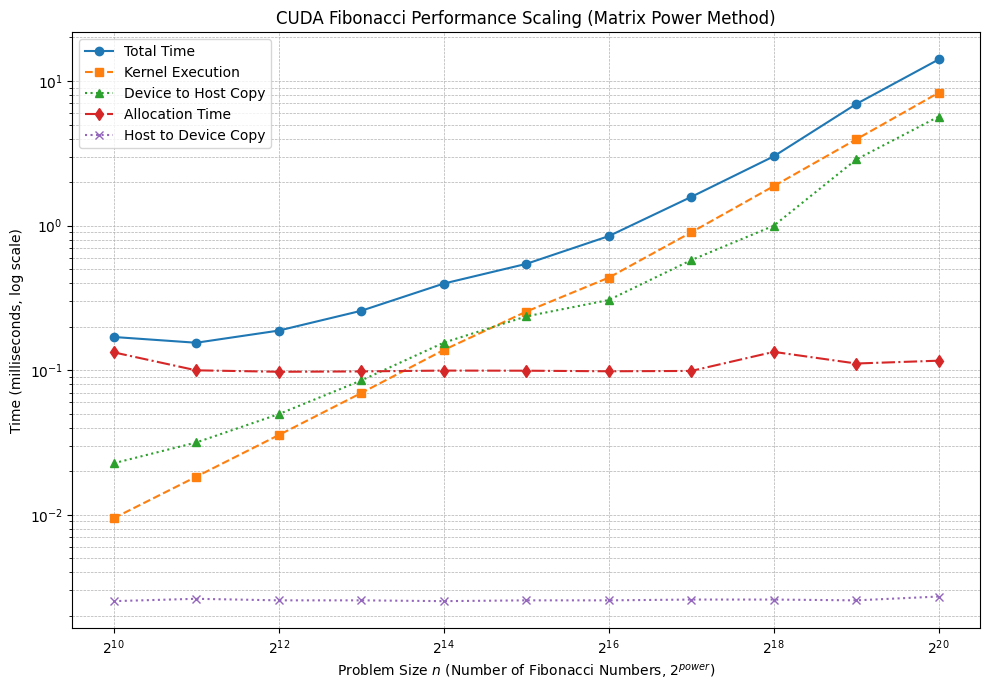

The performance plot shows that this CUDA matrix approach is significantly faster than the sequential CPU (GMP) version, especially for larger N values. After some initial variations at the smallest problem sizes, the Total Time scales consistently upwards with N. This increase is clearly dominated by the Kernel Execution time and, to a lesser extent, the Device-to-Host Copy time. Other factors like Allocation and Host-to-Device copy represent minimal, relatively constant overhead throughout the tested range.

## CUDA Implementation: Sequential Approach (Modulo)
Since fixing the overflow in the CUDA matrix method required complex large-number handling within the kernel, a simpler CUDA approach was also benchmarked. This version runs the standard iterative Fibonacci calculation (F(n)=F(n−1)+F(n−2)) inside each CUDA thread.

To prevent overflow while using standard integer types, all math within the kernel was done modulo 100. This avoids overflow but means the results are not the true Fibonacci numbers for larger N. The main purpose here was to focus only on the timing performance – seeing how well the GPU handles running many simple, iterative tasks in parallel, rather than calculating the correct large values.

In [1]:
code = r"""
// fib_mod_benchmark.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define MODULO_VALUE 100

// Modulo Fibonacci device function
__device__ unsigned int fibonacci_mod(int n) {
    if (n <= 1) return n;

    unsigned int a = 0, b = 1, c;
    for (int i = 2; i <= n; ++i) {
        c = (a + b) % MODULO_VALUE;  // Apply modulo to prevent overflow
        a = b;
        b = c;
    }
    return c;
}

// Single thread kernel that calculates large Fibonacci with modulo
__global__ void single_thread_fibonacci_kernel(int n, unsigned int* result) {
    // Only the first thread performs calculation
    if (threadIdx.x == 0 && blockIdx.x == 0) {
        *result = fibonacci_mod(n);
    }
}


void benchmark_single_thread(int input_size) {
    unsigned int *d_result, h_result;

    // Create CUDA timing events
    cudaEvent_t start, alloc_done, h2d_done, kernel_done, d2h_done, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&alloc_done);
    cudaEventCreate(&h2d_done);
    cudaEventCreate(&kernel_done);
    cudaEventCreate(&d2h_done);
    cudaEventCreate(&stop);

    // Start overall timing
    cudaEventRecord(start);

    // Allocate device memory
    cudaMalloc(&d_result, sizeof(unsigned int));
    cudaEventRecord(alloc_done);

    // (In this example, no host-to-device copy needed before kernel, but we simulate timing)
    cudaEventRecord(h2d_done);

    // Launch kernel with single thread
    single_thread_fibonacci_kernel<<<1, 1>>>(input_size, d_result);
    cudaEventRecord(kernel_done);

    // Copy result back to host
    cudaMemcpy(&h_result, d_result, sizeof(unsigned int), cudaMemcpyDeviceToHost);
    cudaEventRecord(d2h_done);

    // Final stop
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    // Calculate individual elapsed times
    float allocTime = 0, h2dTime = 0, kernelTime = 0, d2hTime = 0, totalTime = 0;
    cudaEventElapsedTime(&allocTime, start, alloc_done);
    cudaEventElapsedTime(&h2dTime, alloc_done, h2d_done);
    cudaEventElapsedTime(&kernelTime, h2d_done, kernel_done);
    cudaEventElapsedTime(&d2hTime, kernel_done, d2h_done);
    cudaEventElapsedTime(&totalTime, start, stop);

    // Print results
    printf("Allocation Time: %.6f ms\n", allocTime);
    printf("Host to Device Copy Time: %.6f ms\n", h2dTime);
    printf("Kernel Execution Time: %.6f ms\n", kernelTime);
    printf("Device to Host Copy Time: %.6f ms\n", d2hTime);
    printf("Total Time: %.6f ms\n", totalTime);

    // Cleanup
    cudaFree(d_result);
    cudaEventDestroy(start);
    cudaEventDestroy(alloc_done);
    cudaEventDestroy(h2d_done);
    cudaEventDestroy(kernel_done);
    cudaEventDestroy(d2h_done);
    cudaEventDestroy(stop);
}



int main() {
    printf("===== Fibonacci Modulo Benchmark =====\n");
    printf("Using modulo %d to prevent overflow\n\n", MODULO_VALUE);

    // Benchmark with various input sizes (powers of 2)
    for (int power = 10; power <= 20; power++) {
        int size = 1 << power;  // 2^power

        printf("\n--- Testing with size = 2^%d = %d ---\n", power, size);

        // Single thread test - one thread does all the work
        benchmark_single_thread(size - 1);


        printf("----------------------------------\n");
    }

    printf("\n===== Benchmark Complete =====\n");
    return 0;
}


"""
with open("fib_cuda_seq.cu", "w") as f:
    f.write(code)

In [2]:
# Compile and run
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 fib_cuda_seq.cu -o fib_cuda_seq
!./fib_cuda_seq

===== Fibonacci Modulo Benchmark =====
Using modulo 100 to prevent overflow


--- Testing with size = 2^10 = 1024 ---
Allocation Time: 0.163872 ms
Host to Device Copy Time: 0.003360 ms
Kernel Execution Time: 1.383136 ms
Device to Host Copy Time: 0.016640 ms
Total Time: 1.569600 ms
----------------------------------

--- Testing with size = 2^11 = 2048 ---
Allocation Time: 0.131456 ms
Host to Device Copy Time: 0.002592 ms
Kernel Execution Time: 0.096352 ms
Device to Host Copy Time: 0.021056 ms
Total Time: 0.254080 ms
----------------------------------

--- Testing with size = 2^12 = 4096 ---
Allocation Time: 0.142240 ms
Host to Device Copy Time: 0.002592 ms
Kernel Execution Time: 0.180512 ms
Device to Host Copy Time: 0.018976 ms
Total Time: 0.346912 ms
----------------------------------

--- Testing with size = 2^13 = 8192 ---
Allocation Time: 0.122720 ms
Host to Device Copy Time: 0.002592 ms
Kernel Execution Time: 0.345408 ms
Device to Host Copy Time: 0.015232 ms
Total Time: 0.488544 m

### Results Analysis: CUDA Sequential Approach

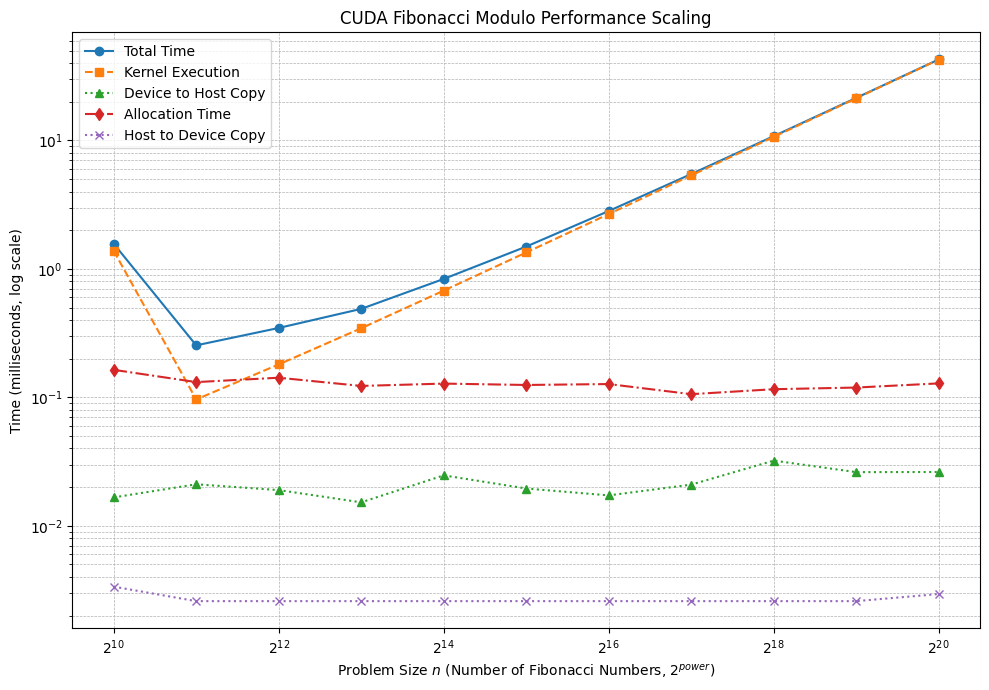

Comparing the timing results, this sequential-in-thread CUDA approach is clearly slower overall than the CUDA matrix method. The plot shows an unusual spike in kernel and total time for the smallest size (N=2^10). This might be due to initial GPU warm-up effects, measurement noise, or one-time kernel launch overheads.

After that initial point (N ≥ 2^11), the performance becomes more predictable. The Total Time increases consistently as N gets larger. Looking at the components, this increase is almost entirely driven by the Kernel Execution time, which scales clearly with the problem size. Other overheads, like memory allocation and data transfers, remain relatively low and constant compared to the kernel time.

## Final Analysis & Conclusion

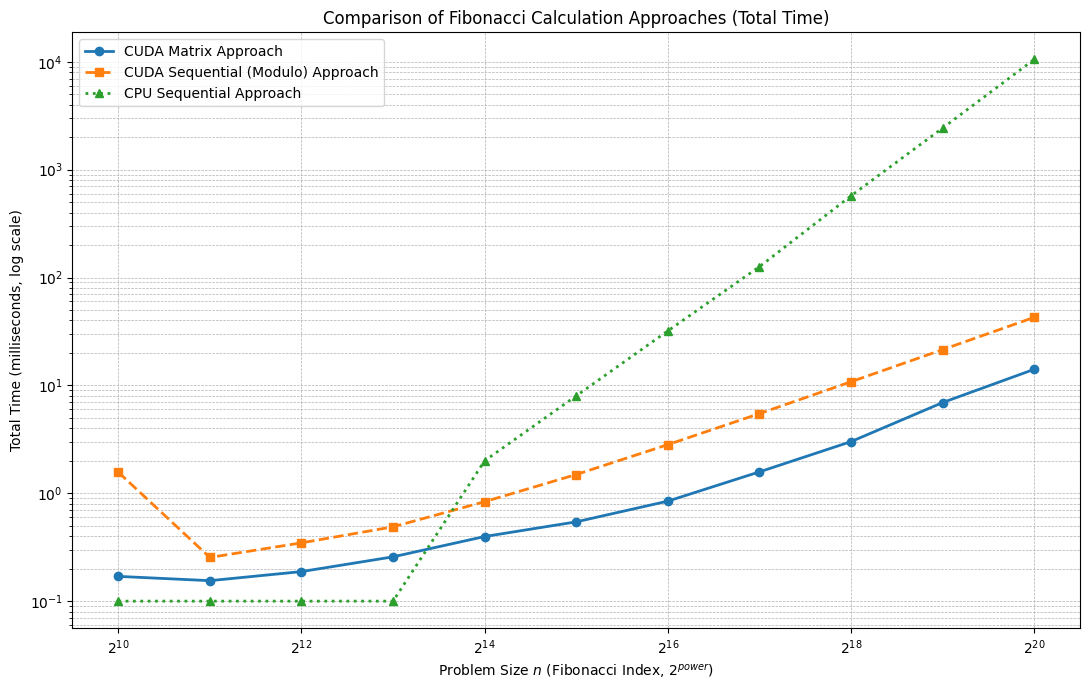

The final plot puts the total run times of all three approaches side-by-side: CPU sequential (using GMP), CUDA sequential (single-thread), and CUDA matrix (parallel).

Let's first compare the CPU method with the single-threaded CUDA (modulo) version. The CPU code starts very fast for small N but gets significantly slower as N increases, likely due to the overhead involved in handling very large numbers with the GMP library. The CUDA version, even though it only uses one thread for the calculation, shows better scaling. It actually becomes faster than the CPU version starting around N = 2^14

Why does a single GPU thread eventually beat the CPU using a specialized library? Since it's not using parallelism for the Fibonacci calculation itself, the advantage might come down to the GPU hardware perhaps being more efficient at this specific type of simple loop with modulo operations, or maybe the GMP library adds more overhead on the CPU side than the basic CUDA setup does for this task. It shows that performance comparisons aren't always just about parallel algorithms; hardware architecture and library overhead matter too.